In [43]:
from imports import *
from periodogram import compute_LSperiodogram
from read_data import *
from bgls import bgls
from rvmodel import get_rv1
from priors import *
from autocorrDFM import *
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
# get data
bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = read_HARPS()
#g =  [5 48 83] 3.69 days
#g = [] 7.45 days
print bjd.size

-5678.16
114


## visualize data

<Container object of 3 artists>

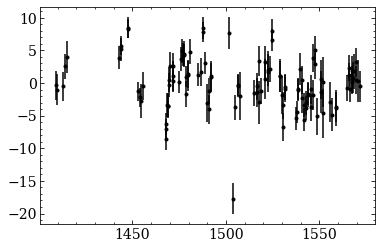

In [3]:
# plot RVs
t0 = 2457000
plt.errorbar(bjd-t0, rv, erv, fmt='k.')

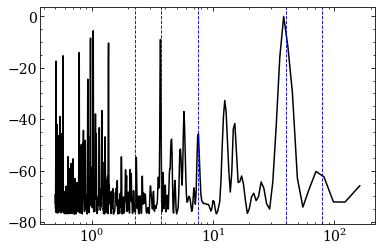

In [4]:
per,pwr = bgls(bjd, rv, erv, plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
plt.plot(per, np.log(pwr), 'k-')
plt.xscale('log')
Ps = [2.25,3.69,7.45,80,40]
for p in Ps:
    plt.axvline(p, ls='--', lw=.9, color='b')

## run LOOCV on the remaining planet periods

In [5]:
def run_loocv(P, bjd, rv, erv, mu, kepmodel):
    '''Investigate the strength of a particular periodicity by omitting individual measurements.'''
    assert bjd.size == rv.size
    assert bjd.size == erv.size
    assert bjd.size == mu.size
    assert bjd.size == kepmodel.size
    
    prob_P = np.zeros(bjd.size)
    for i in range(bjd.size):
        # compute BGLS
        bjd_red = np.delete(bjd, i)
        rv_red = np.delete(rv-mu-kepmodel, i)
        erv_red = np.delete(erv, i)
        per,prob = bgls(bjd_red, rv_red, erv_red, plow=.5, phigh=2e2, n_steps=1e3)
        
        # what is the probability of the period of interest?
        g = np.isclose(per, P, rtol=.01)
        prob_P[i] = prob[g].max()
        
    return prob_P

In [27]:
# get MCMC results
#samples = fits.open('output_data/3planets_TOI175_H113_HalphaGP_samplesv2')[0].data
#results = get_results(samples)
_,_,_,_,_,V,Pc,T0c,Kc,hc,kc,_,_,_,_,_,_,_,_,_,_ = results[0]
kepc = get_rv1((Pc,T0c,0,Kc,hc,kc), bjd)

In [41]:
# run loocv
print Ps
prob_P1 = run_loocv(Ps[1], bjd, rv, erv, np.zeros(bjd.size), np.zeros(bjd.size))
#prob_P1 = run_loocv(Ps[2], bjd, rv-V-kepc, erv, np.zeros(bjd.size), np.zeros(bjd.size))

[2.25, 3.69, 7.45, 80, 40]


[48 83]
0.002343515885678098
0.00684345101477128
0.009352140962360964


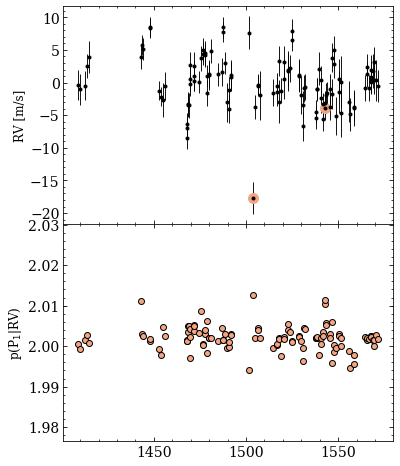

In [57]:
# plot loocv results
t0 = 2457000#bjd.min()
cols = ['#67001f','#f4a582','#92c5de','#d6604d']

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,4)
ax1 = plt.subplot(gs[0,:-1])
ax1.errorbar(bjd-t0, rv, erv, fmt='k.', elinewidth=.9)
b1 = (abs(prob_P1-prob_P1.mean()) > np.percentile(abs(prob_P1-prob_P1.mean()), 99))
#b2 = (abs(prob_P2-prob_P2.mean()) > np.percentile(abs(prob_P2-prob_P2.mean()), 99))
print np.where(b1)[0]#, np.where(b2)[0], '\n'
ax1.plot(bjd[b1]-t0, rv[b1], 'o', c=cols[1], ms=10)
ax1.set_ylabel('RV [m/s]', fontsize=12)
ax1.set_xticklabels('')

ax2 = plt.subplot(gs[1,:-1])
prob_P1 = np.log10(prob_P1)
ax2.scatter(bjd-t0, prob_P1, facecolor=cols[1], edgecolors='k')
for i in [68,95,99]:
    v = np.percentile(abs(prob_P1-np.mean(prob_P1)), i)
    print v
    #ax2.fill_between(bjd-t0, v, -v, alpha=.1, color='k')
ax2.set_ylabel('p(P$_1$|RV)', fontsize=12)
#ax2.set_yscale('log')

#ax3 = plt.subplot(gs[1,-1])
#y,x = np.histogram(prob_P1, bins=1000)
#x, y = x[:-1]+np.diff(x)/2, np.cumsum(y) / np.sum(y)
#ax3.plot(y, x, '-')

plt.subplots_adjust(hspace=0)
#plt.savefig('/Users/ryancloutier/Research/TOI_175/plots/loocv_3d69.png')

[48 83]


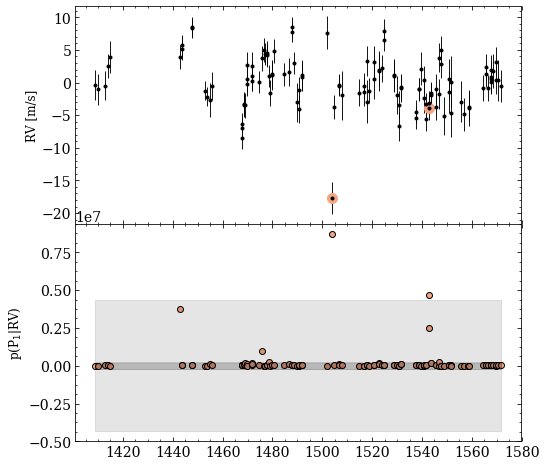

In [42]:
# plot loocv results
t0 = 2457000#bjd.min()
cols = ['#67001f','#f4a582','#92c5de','#d6604d']

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax1.errorbar(bjd-t0, rv, erv, fmt='k.', elinewidth=.9)
b1 = (abs(prob_P1-prob_P1.mean()) > np.percentile(abs(prob_P1-prob_P1.mean()), 99))
#b2 = (abs(prob_P2-prob_P2.mean()) > np.percentile(abs(prob_P2-prob_P2.mean()), 99))
print np.where(b1)[0]#, np.where(b2)[0], '\n'
ax1.plot(bjd[b1]-t0, rv[b1], 'o', c=cols[1], ms=10)
ax1.set_ylabel('RV [m/s]', fontsize=12)
ax1.set_xticklabels('')

ax2 = fig.add_subplot(212)
prob_P1 *= 1e8
ax2.scatter(bjd-t0, prob_P1, facecolor=cols[1], edgecolors='k')
for i in [68,95,99]:
    v = np.percentile(abs(prob_P1-np.mean(prob_P1)), i)
    ax2.fill_between(bjd-t0, v, -v, alpha=.1, color='k')
ax2.set_ylabel('p(P$_1$|RV)', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.savefig('/Users/ryancloutier/Research/TOI_175/plots/loocv_3d69.png')

## plot periodograms

In [ ]:
# plot periograms
Prot = 80
Ps = [2.25,3.69,7.45,Prot,Prot/2.]
xs = [bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd]
ys = [rv, bjd, fwhm, bis, Halpha, Hbeta, Hgamma, NaD, Sindex]
eys = [erv, erv, np.ones(bjd.size), np.ones(bjd.size), eHalpha, eHbeta, eHgamma, eNaD, eSindex]
labels = ['RV','WF','FWHM','BIS','Halpha','Hbeta','Hgamma','NaD','Sindex']
for i in range(len(xs)):
    #per,pwr = bgls(xs[i], ys[i], eys[i], plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
    per,_,pwr = compute_LSperiodogram(xs[i], ys[i], eys[i], plims=(.5,bjd.max()-bjd.min()))
    plt.figure(i, figsize=(8,4))
    plt.plot(per, pwr, 'k-'), plt.xscale('log')
    plt.ylabel('BGLS %s'%labels[i], fontsize=12), plt.xlabel('Period [days]', fontsize=12)
    for p in Ps:
        plt.axvline(p, ls='--', lw=.9, color='b')